## Hypothesis

Our final ensemble (and all L2 models) is not predicting anything under 20. Creating a classifier able to identify samples with a Pawpularity under 20 could improve the final ensemble.

In [1]:
from ml.vision.data import ImageDataModule
from ml.learner import ImageClassifier
from ml.params import load_cfg

In [2]:
import pandas as pd

df = pd.read_csv("../data/train_folds.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold,ignore
0,0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0,0
1,1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2,0
2,2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,3,0
3,3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3,1
4,4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,1,0


In [3]:
train_image_fpaths = [f"../data/train/{i}.jpg" for i in df[df.kfold!=0]["Id"]]
train_targets = [[1] if t <= 20 else [0] for t in df[df.kfold!=0].Pawpularity.tolist()]

In [4]:
val_image_fpaths = [f"../data/train/{i}.jpg" for i in df[df.kfold==0]["Id"]]
val_targets = [[1] if t <= 20 else [0] for t in df[df.kfold==0].Pawpularity.tolist()]

In [5]:
train_image_fpaths[:5]

['../data/train/0009c66b9439883ba2750fb825e1d7db.jpg',
 '../data/train/0013fd999caf9a3efe1352ca1b0d937e.jpg',
 '../data/train/0018df346ac9c1d8413cfcc888ca8246.jpg',
 '../data/train/001dc955e10590d3ca4673f034feeef2.jpg',
 '../data/train/001dd4f6fafb890610b1635f967ea081.jpg']

In [6]:
train_targets[:5]

[[0], [0], [1], [0], [0]]

In [80]:
cfg = load_cfg("../params.yaml", cfg_name="train_two")
cfg.metric = 'auc'
cfg.metric_mode = 'max'
cfg

{'name': 'two', 'seed': 7591, 'n_folds': 5, 'fold': -1, 'metric': 'auc', 'metric_mode': 'max', 'train_data': 'data/train', 'arch': 'swin_large_patch4_window7_224', 'pretrained': True, 'epochs': 6, 'bs': 64, 'auto_batch_size': False, 'accumulate_grad_batches': 1, 'precision': 'bf16', 'use_normalize': True, 'n_tfms': 1, 'magn': 5, 'sz': 224, 'use_mix': 0, 'mix_p': 0.0, 'resize': -1, 'dropout': 0.0, 'wd': 0.0, 'label_smoothing': 0.1, 'loss': 'bce_with_logits', 'opt': 'adamw', 'sched': 'cosine', 'warmup_epochs': 1, 'lr': 5e-05, 'auto_lr': False, 'mom': 0.9}

In [81]:
from timm.data import transforms_factory

train_aug = transforms_factory.create_transform(
    input_size=cfg.sz,
    is_training=True,
    auto_augment=f"rand-n{cfg.n_tfms}-m{cfg.magn}",
)
val_aug = transforms_factory.create_transform(
    input_size=cfg.sz,
    is_training=False,
)

In [82]:
dm = ImageDataModule(
    task="classification",
    batch_size=cfg.bs,
    # train
    train_image_paths=train_image_fpaths,
    train_targets=train_targets,
    train_augmentations=train_aug,
    # valid
    val_image_paths=val_image_fpaths,
    val_targets=val_targets,
    val_augmentations=val_aug,
    # test
    test_image_paths=val_image_fpaths,
    test_augmentations=val_aug,
)

In [83]:
model = ImageClassifier(
    in_channels=3,
    num_classes=1,
    pretrained=cfg.pretrained,
    cfg=cfg,
)

In [84]:
import pytorch_lightning as pl 

trainer = pl.Trainer(
    gpus=1,
    precision=cfg.precision,
    auto_lr_find=cfg.auto_lr,
    accumulate_grad_batches=cfg.accumulate_grad_batches,
    auto_scale_batch_size=cfg.auto_batch_size,
    max_epochs=cfg.epochs,
#     logger=logger,
#     callbacks=[checkpoint_callback, lr_callback],
    # limit_train_batches=1,
    # limit_val_batches=1,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [85]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TrainerFn.FITTING



  | Name         | Type            | Params
-------------------------------------------------
0 | backbone     | SwinTransformer | 194 M 
1 | head         | Sequential      | 8.3 K 
2 | train_metric | AUROC           | 0     
3 | val_metric   | AUROC           | 0     
-------------------------------------------------
195 M     Trainable params
0         Non-trainable params
195 M     Total params
780.015   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 1 // train metric: 0.5142, valid metric: 0.5951


Validating: 0it [00:00, ?it/s]

Epoch 2 // train metric: 0.5427, valid metric: 0.6030


Validating: 0it [00:00, ?it/s]

Epoch 3 // train metric: 0.5674, valid metric: 0.6017


Validating: 0it [00:00, ?it/s]

Epoch 4 // train metric: 0.5947, valid metric: 0.6048


Validating: 0it [00:00, ?it/s]

Epoch 5 // train metric: 0.6250, valid metric: 0.6077


In [87]:
preds = trainer.predict(model, dm.test_dataloader(), ckpt_path="best")
preds_list = [p[0] for b in preds for p in b]

Restoring states from the checkpoint path at /workspace/nbs/lightning_logs/version_93/checkpoints/epoch=5-step=737.ckpt


TrainerFn.PREDICTING


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/nbs/lightning_logs/version_93/checkpoints/epoch=5-step=737.ckpt


Predicting: 123it [00:00, ?it/s]

In [88]:
import numpy as np

preds = np.array(preds_list)

In [89]:
preds.min(), preds.max()

(0.028442383, 0.56640625)

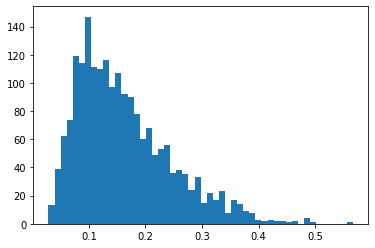

In [90]:
import matplotlib.pyplot as plt

plt.hist(preds, bins=50);

In [91]:
from sklearn.metrics import precision_score

precision_score(val_targets, preds> 0.50)

0.0

In [92]:
np.sum(val_targets) / len(val_targets)

0.14227848101265822

In [93]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(val_targets, preds)

In [94]:
np.argmax(tpr - fpr)

132

In [95]:
from sklearn.metrics import roc_curve

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


threshold = Find_Optimal_Cutoff(val_targets, preds)
threshold

[0.16015625]

In [96]:
np.sum(preds > 0.16)

850

In [97]:
preds

array([0.11572266, 0.23828125, 0.06176758, ..., 0.12353516, 0.39453125,
       0.10107422], dtype=float32)